# タスクの概要

**目標**　患者の11の特徴から心臓病か否かを分類する。

データは、`data`ディレクトリに`train.csv`, `test.csv`という名前のデータがあります。記録されている特徴量は以下のとおりです。学習モデルを作るときには、`train.csv`のみを用いてよいものとします。以下の2つのことに挑戦してください。

1. 心臓病になりやすい患者さんとはどんなひとかを説明してください。
2. デモでみせるモデルよりも`test.csv`の上で精度の高いモデルを作ってください。

* Age : 患者の年齢
* Sex : 患者の性別
    * `1`は男性, `0`は女性
* ChestPainType : 筋痛の種類
    * `TA`は典型的狭心症, `ATA`は非典型狭心症, `NAP`は非狭心症の痛み, `ASY`は無症状
* RestingBP : 安静時血圧
* Cholesterol : 血清コレステロール値
* FastingBS : 空腹時血糖値
    * `1`は~FastingBS>1~`>120 mg/dl`, `0`はそれ以外
* RestingECG : 安静時心電図結果
    * `Normal`は正常, `ST`はST-T波に異常, `LVH`は左心室肥大の可能性・確定
* MaxHR : 到達最大心拍数
* ExerciseAngina : 運動誘発性狭心症
    * `1`はあり, `0`はなし
* Oldpeak : ~うつ状態で測定された数値~　安静時と比較して運動により誘発されたST低下
* ST_Slope : 運動時のSTピークセグメントの動き。低下した上でupslopingというのもあるっぽい。
    * `Up`はupsloping, `flat`は平坦, `Down`はdownsloping

心臓病かいなかは`HeartDisease`に`1`が心臓病, `0`が正常として記録されています。

# import

In [132]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

np.set_printoptions(linewidth=200)
pd.set_option('display.max_rows', 100)

# データの概観

In [2]:
df_orig = pd.read_csv('./data/train.csv')

In [3]:
df0 = df_orig.copy()
display(df0.head())

print(df0.isna().sum())

# Cholesterol列の0をNaNに変換する
df0.loc[df0['Cholesterol'] == 0, 'Cholesterol'] = np.nan

# One-Hotエンコーディングする(冗長な列も残しておく)
df0_y = df0['HeartDisease'] # 目的変数を一旦避難させる
df0 = df0.drop(columns='HeartDisease')
df0 = pd.get_dummies(df0, drop_first=False)
df0.insert(loc=0, column='HeartDisease', value=df0_y) # 目的変数を先頭に結合する

display(df0.head())
print(df0.shape)

print(df0.isna().sum())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,56,1,ASY,155,342,1,Normal,150,1,3.0,Flat,1
1,55,0,ATA,130,394,0,LVH,150,0,0.0,Up,0
2,47,1,NAP,110,0,1,Normal,120,1,0.0,Flat,1
3,34,1,ASY,115,0,1,Normal,154,0,0.2,Up,1
4,54,0,NAP,160,201,0,Normal,163,0,0.0,Up,0


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1,56,1,155,342.0,1,150,1,3.0,1,0,0,0,0,1,0,0,1,0
1,0,55,0,130,394.0,0,150,0,0.0,0,1,0,0,1,0,0,0,0,1
2,1,47,1,110,NaN,1,120,1,0.0,0,0,1,0,0,1,0,0,1,0
3,1,34,1,115,NaN,1,154,0,0.2,1,0,0,0,0,1,0,0,0,1
4,0,54,0,160,201.0,0,163,0,0.0,0,0,1,0,0,1,0,0,0,1


(642, 19)
HeartDisease           0
Age                    0
Sex                    0
RestingBP              0
Cholesterol          123
FastingBS              0
MaxHR                  0
ExerciseAngina         0
Oldpeak                0
ChestPainType_ASY      0
ChestPainType_ATA      0
ChestPainType_NAP      0
ChestPainType_TA       0
RestingECG_LVH         0
RestingECG_Normal      0
RestingECG_ST          0
ST_Slope_Down          0
ST_Slope_Flat          0
ST_Slope_Up            0
dtype: int64


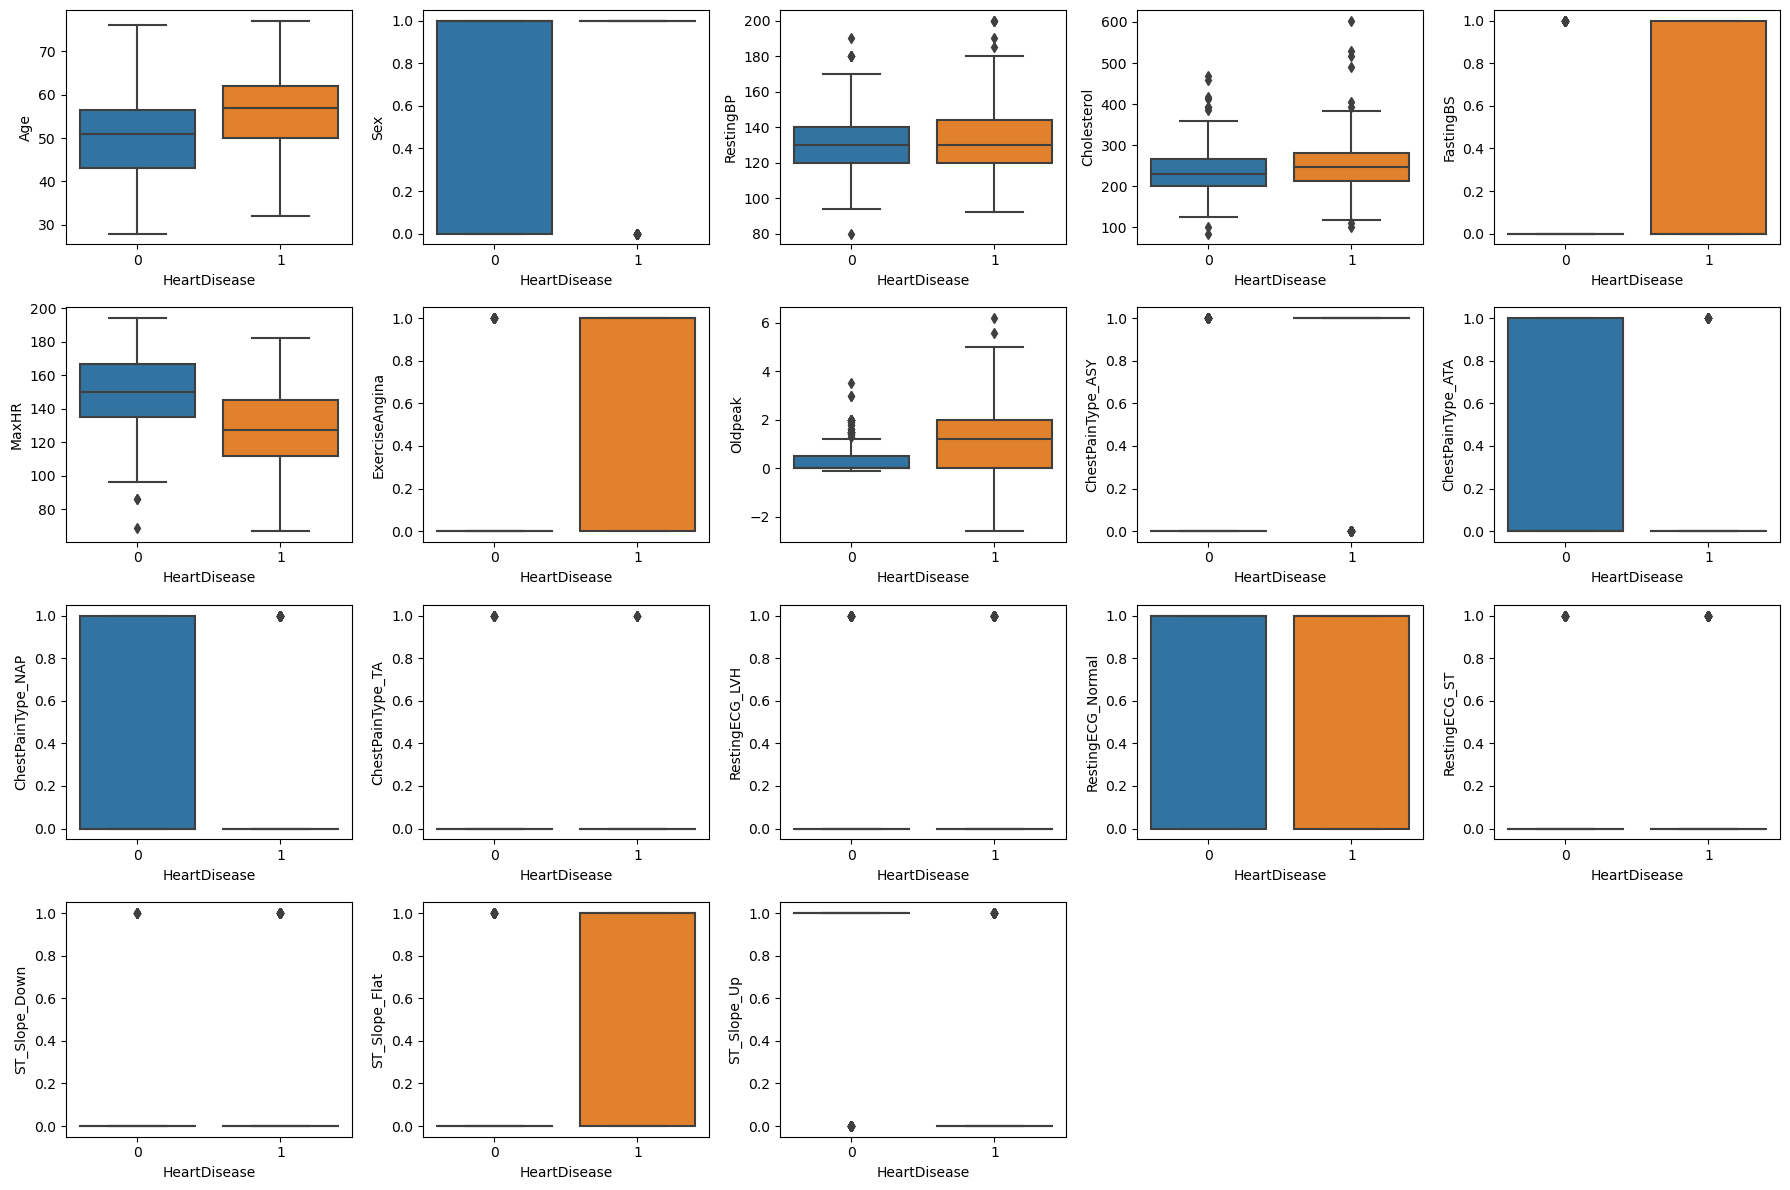

In [4]:
# 良性/悪性で分けた箱ヒゲ図を描く
fig =plt.figure(figsize=[18,12])
for i in range(0, df0.shape[1]-1):
    axi = plt.subplot(4, 5, i+1)
    sns.boxplot(data=df0, x=df0.iloc[:, 0], y=df0.iloc[:, i+1], ax=axi)
    plt.tight_layout() # 体裁をきれいにするおまじない
plt.show()

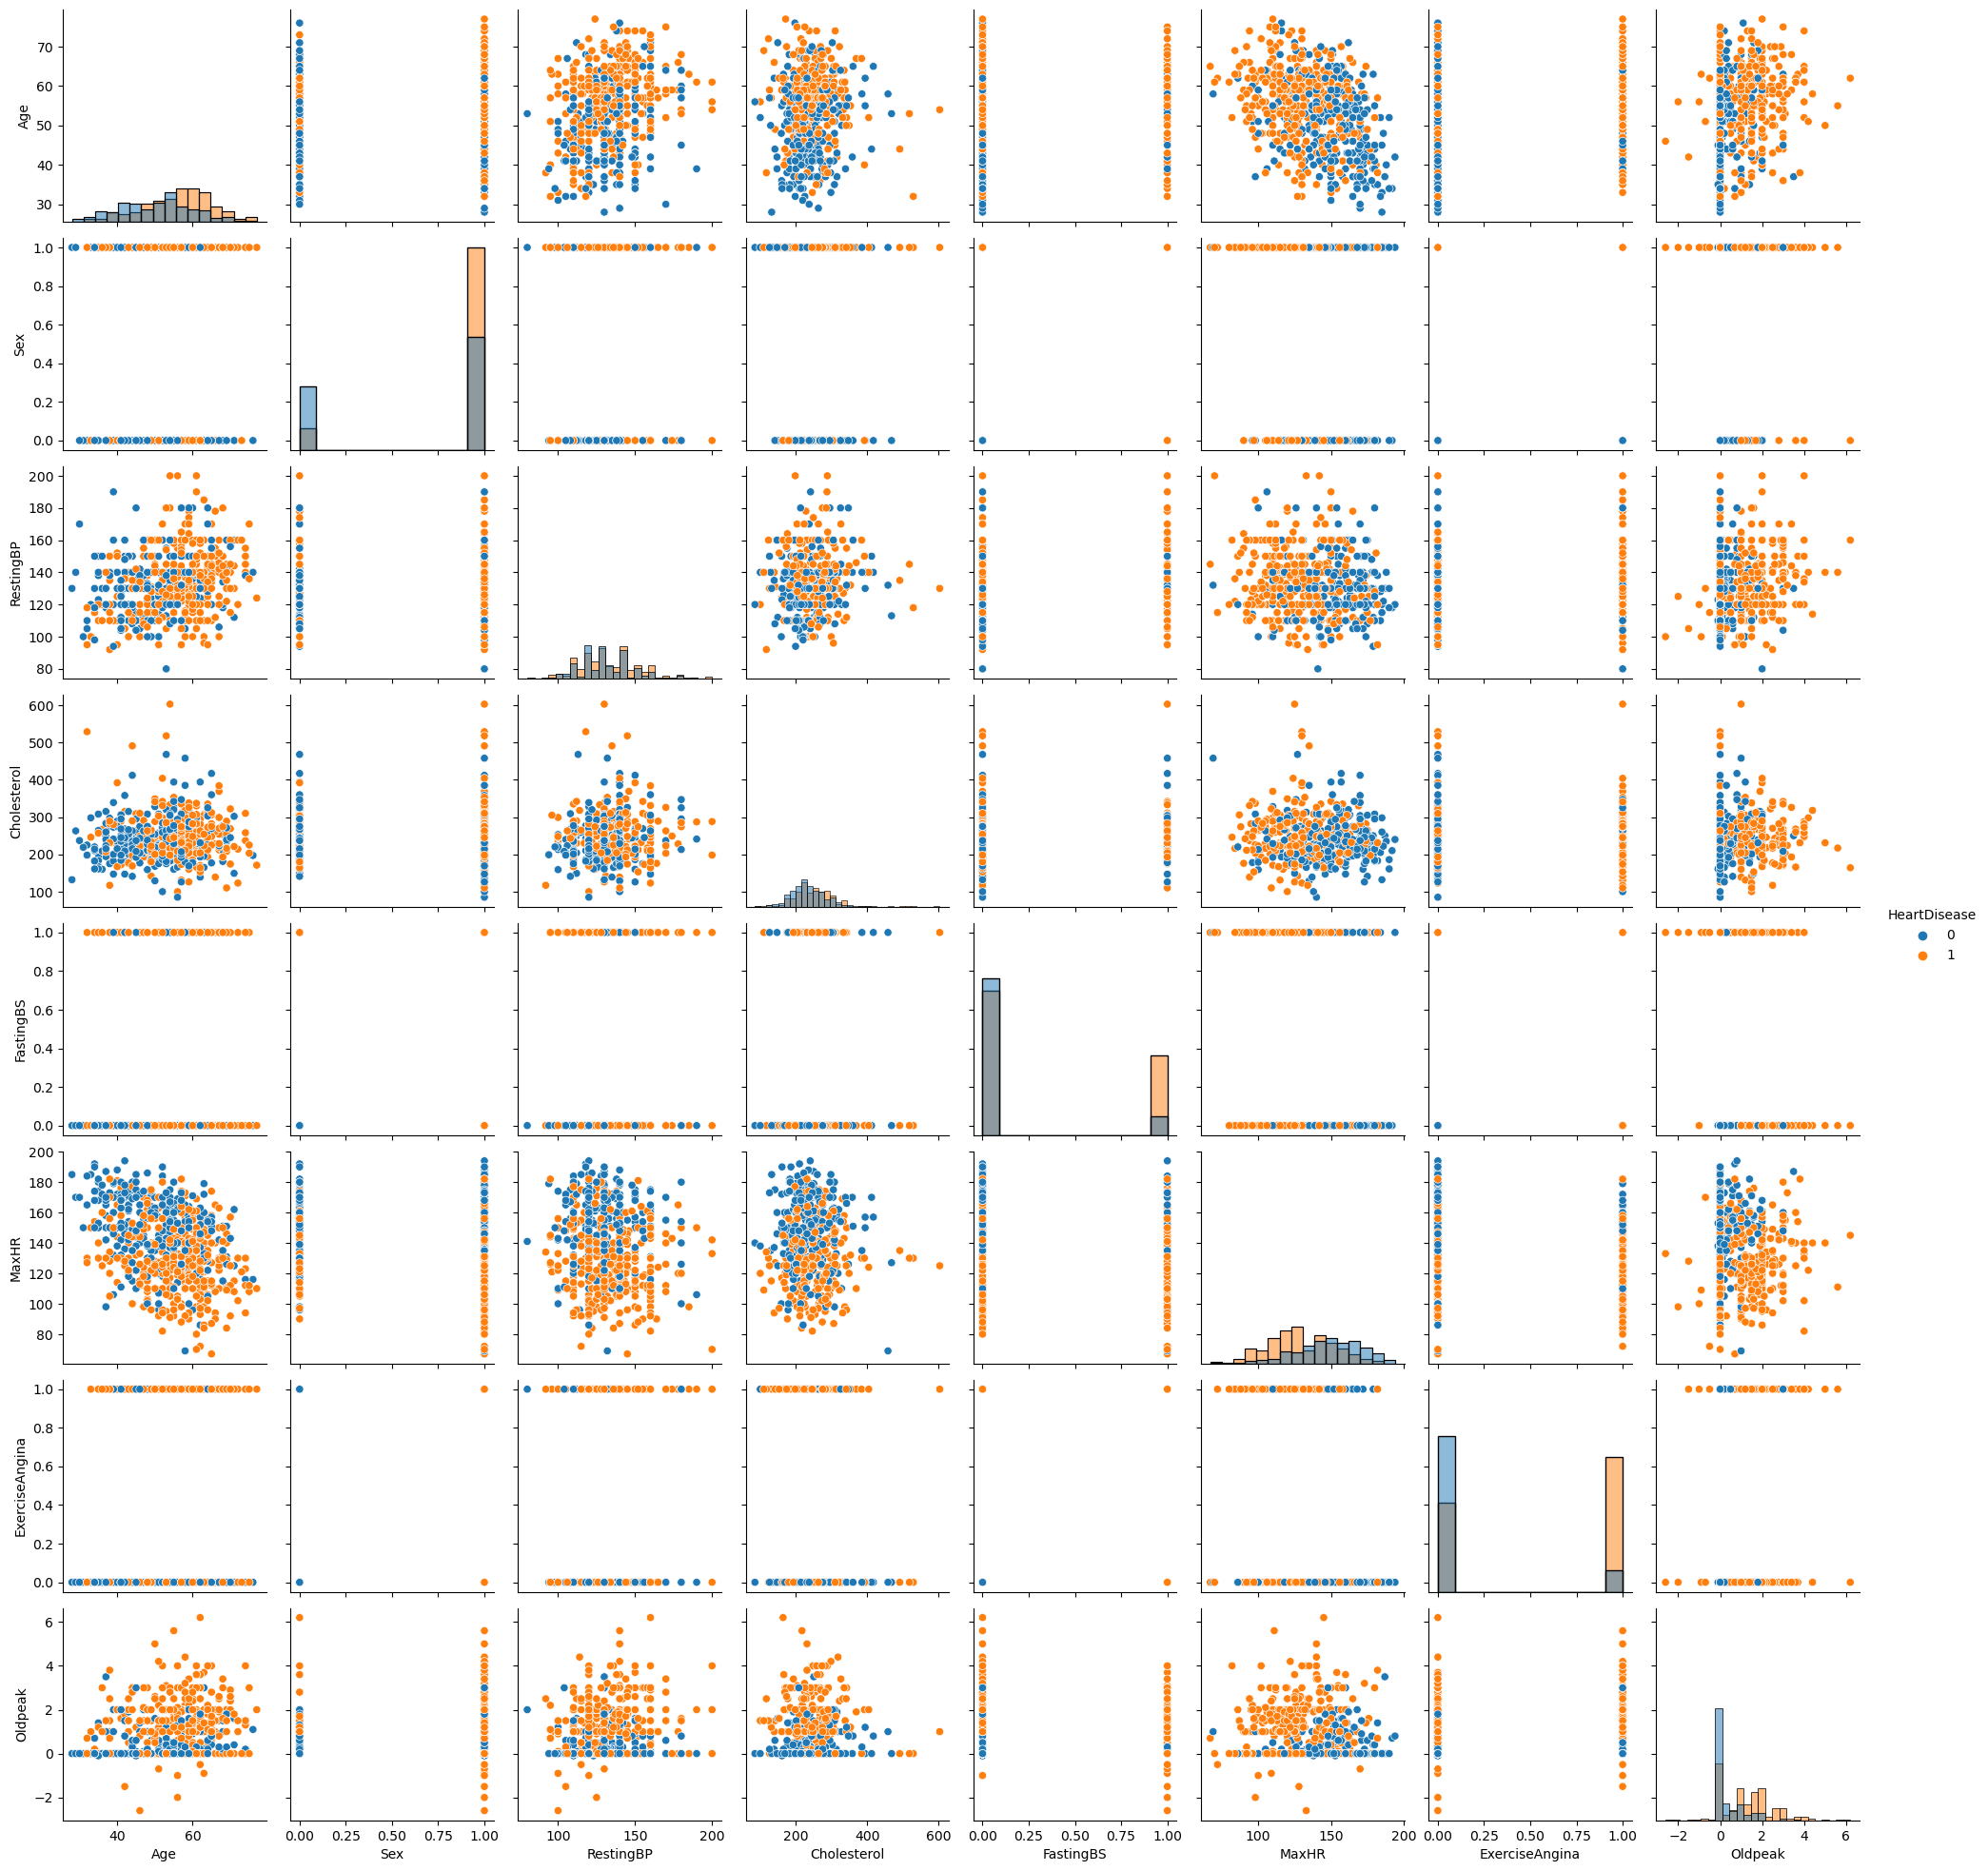

In [6]:
sns.pairplot(data=df0.iloc[:, :9],diag_kind="hist", hue='HeartDisease')
plt.show()

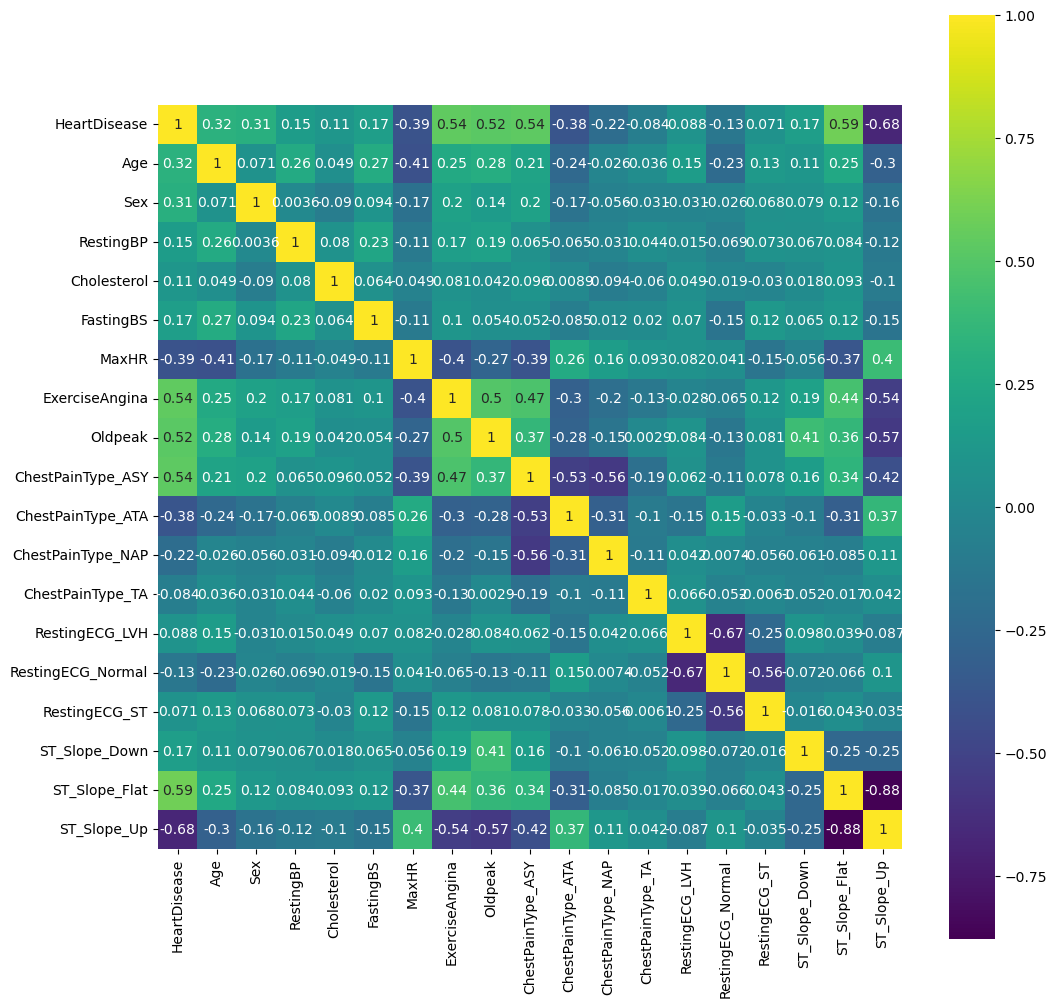

In [5]:
cm = np.corrcoef(df0.dropna(how='any').values.T)

plt.figure(figsize = (12, 12))
heat_map = sns.heatmap(cm, xticklabels=df0.columns, yticklabels=df0.columns, cmap='viridis', annot=True, square=True)

In [7]:
df0.describe()

,HeartDisease,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,642.000000,642.000000,642.000000,642.000000,519.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,0.559190,53.556075,0.786604,132.101246,243.414258,0.247664,137.395639,0.389408,0.876791,0.545171,0.190031,0.232087,0.032710,0.188474,0.618380,0.193146,0.076324,0.492212,0.431464
std,0.496871,9.542620,0.410024,18.006691,59.626572,0.431992,24.624338,0.487996,1.084168,0.498344,0.392631,0.422494,0.178016,0.391395,0.486163,0.395075,0.265723,0.500329,0.495667
min,0.000000,28.000000,0.000000,80.000000,85.000000,0.000000,67.000000,0.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,47.000000,1.000000,120.000000,208.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,54.000000,1.000000,130.000000,235.000000,0.000000,139.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,61.000000,1.000000,140.000000,274.000000,0.000000,156.000000,1.000000,1.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,77.000000,1.000000,200.000000,603.000000,1.000000,194.000000,1.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 説明変数について考える

[1](https://med.toaeiyo.co.jp/contents/ecg/pdf/ecg2-2.pdf)<br>
[2](https://www.j-circ.or.jp/cms/wp-content/uploads/2020/02/JCS2018_yamagishi_tamaki.pdf)

労作性狭心症
- 運動時には、心筋の酸素需要が上昇するも、冠状動脈の狭窄により酸素供給が追いつかず、心筋虚血により胸痛をもたらす
- 運動時にはSTが低下する → Oldpeakが正の値
- 安静時には異常は見られない → RestingECG_STは0
- 運動時のST低下には、右下がり、水平、右上がりがある → 低下していることが重要なので、この3つの区別には意味がない?ST_Slope_Down, ST_Slope_Flat, ST_Slope_Upのこと?

安静狭心症
- 冠状動脈のけいれんによる心筋虚血により胸痛をもたらす
- 心内膜側だけが虚血しているとST低下、心外膜側まで虚血しているとST上昇 → STでは見分けられない?

胸痛の種類の中で最も目的変数と相関しているのがChestPainType_ASYな時点で、かなり特殊な病態を目的変数なのでは?痛みを伴わない病態が目的変数なので、そもそも狭心症ではないのでは?<br>

ExerciseAnginaも目的変数と相関している。これは、ChestPainType_ASYが目的変数と相関していることと矛盾する。

まずはExerciseAnginaとChestPainType_ASYで散布図を描いてみるべき。

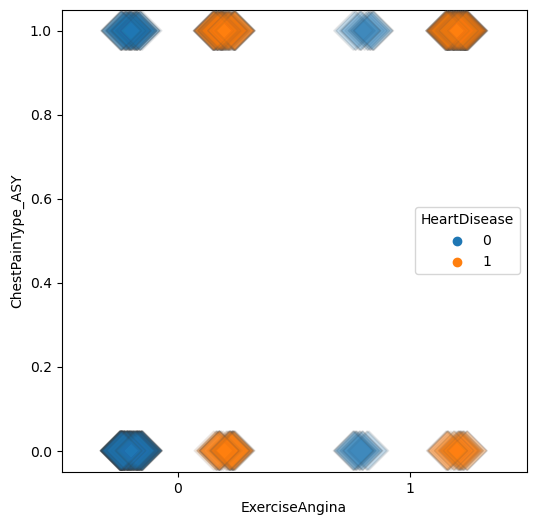

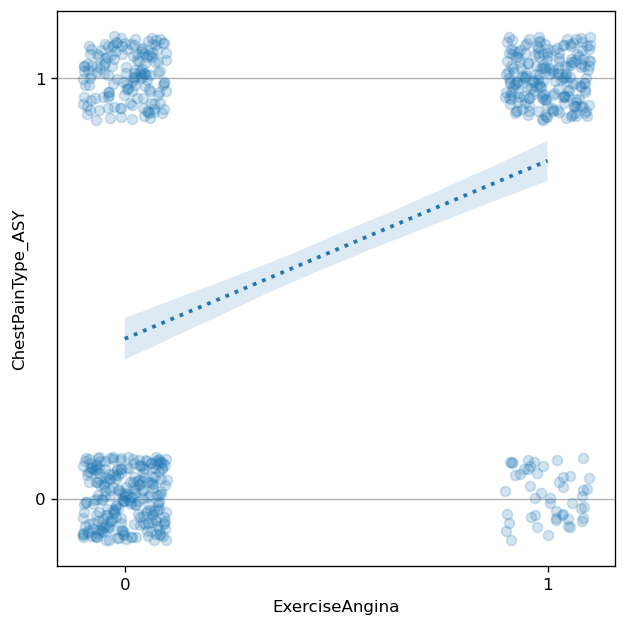

In [290]:


plt.figure(figsize=(6, 6)) # 図の大きさを設定する

# sns.swarmplot(data=df0, # swarmplotで蜂の巣状の散布図を描画する
#               x='ExerciseAngina',
#               y='ChestPainType_ASY',
#               hue='HeartDisease')

sns.stripplot(data=df0, # swarmplotで蜂の巣状の散布図を描画する
              x='ExerciseAngina',
              y='ChestPainType_ASY',
              hue='HeartDisease',
              alpha=0.1,
              jitter=0.1,
              dodge=True,
              s=20,
              marker="D",
              linewidth=1)

plt.figure(figsize=(6,6),dpi=120)
plt.gcf().patch.set_facecolor('white')
ax = plt.gca() 
ax = sns.regplot(data=df0, x='ExerciseAngina', y='ChestPainType_ASY', x_jitter=.1, y_jitter=.1, scatter_kws={'alpha':0.2},line_kws={'linestyle':':'})
ax.set( xticks=range(0,2), yticks=range(0, 2))
ax.set_axisbelow(True)
ax.grid(axis='y')
plt.show()

# 前処理(冗長な列をdropする、説明変数をdropする、dropna()、train_test_split())

In [235]:
# 説明変数と目的変数を決める
df = df0.copy()
# df = df.drop(columns=['ChestPainType_TA', 'RestingECG_ST', 'ST_Slope_Down']) # 冗長な列をdropする
df = df.drop(columns=['Cholesterol']) # 欠損地の多いCholesterol列をdropする
df = df.dropna()

y = df['HeartDisease']
X = df.drop(columns='HeartDisease')

cols = df.iloc[:, 1:].columns
# cols = ['ST_Slope_Up', 'ChestPainType_ASY']
X = X[cols]

print(X.shape)

# 学習用データとテスト用データに分ける
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=2)

(642, 17)


In [236]:
# 標準化する
sscaler = StandardScaler()
X_train_ss = sscaler.fit_transform(X_train)
X_test_ss = sscaler.fit_transform(X_test)

# 特徴量を減らす

In [204]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

## 特徴量選択

### L1正則化したロジスティック回帰
[# ロジスティック回帰(限界がある)](#ロジスティック回帰(限界がある))

### 決定木

学習用データでの正解率: 0.9044834307992202
テスト用データでの正解率: 0.8294573643410853


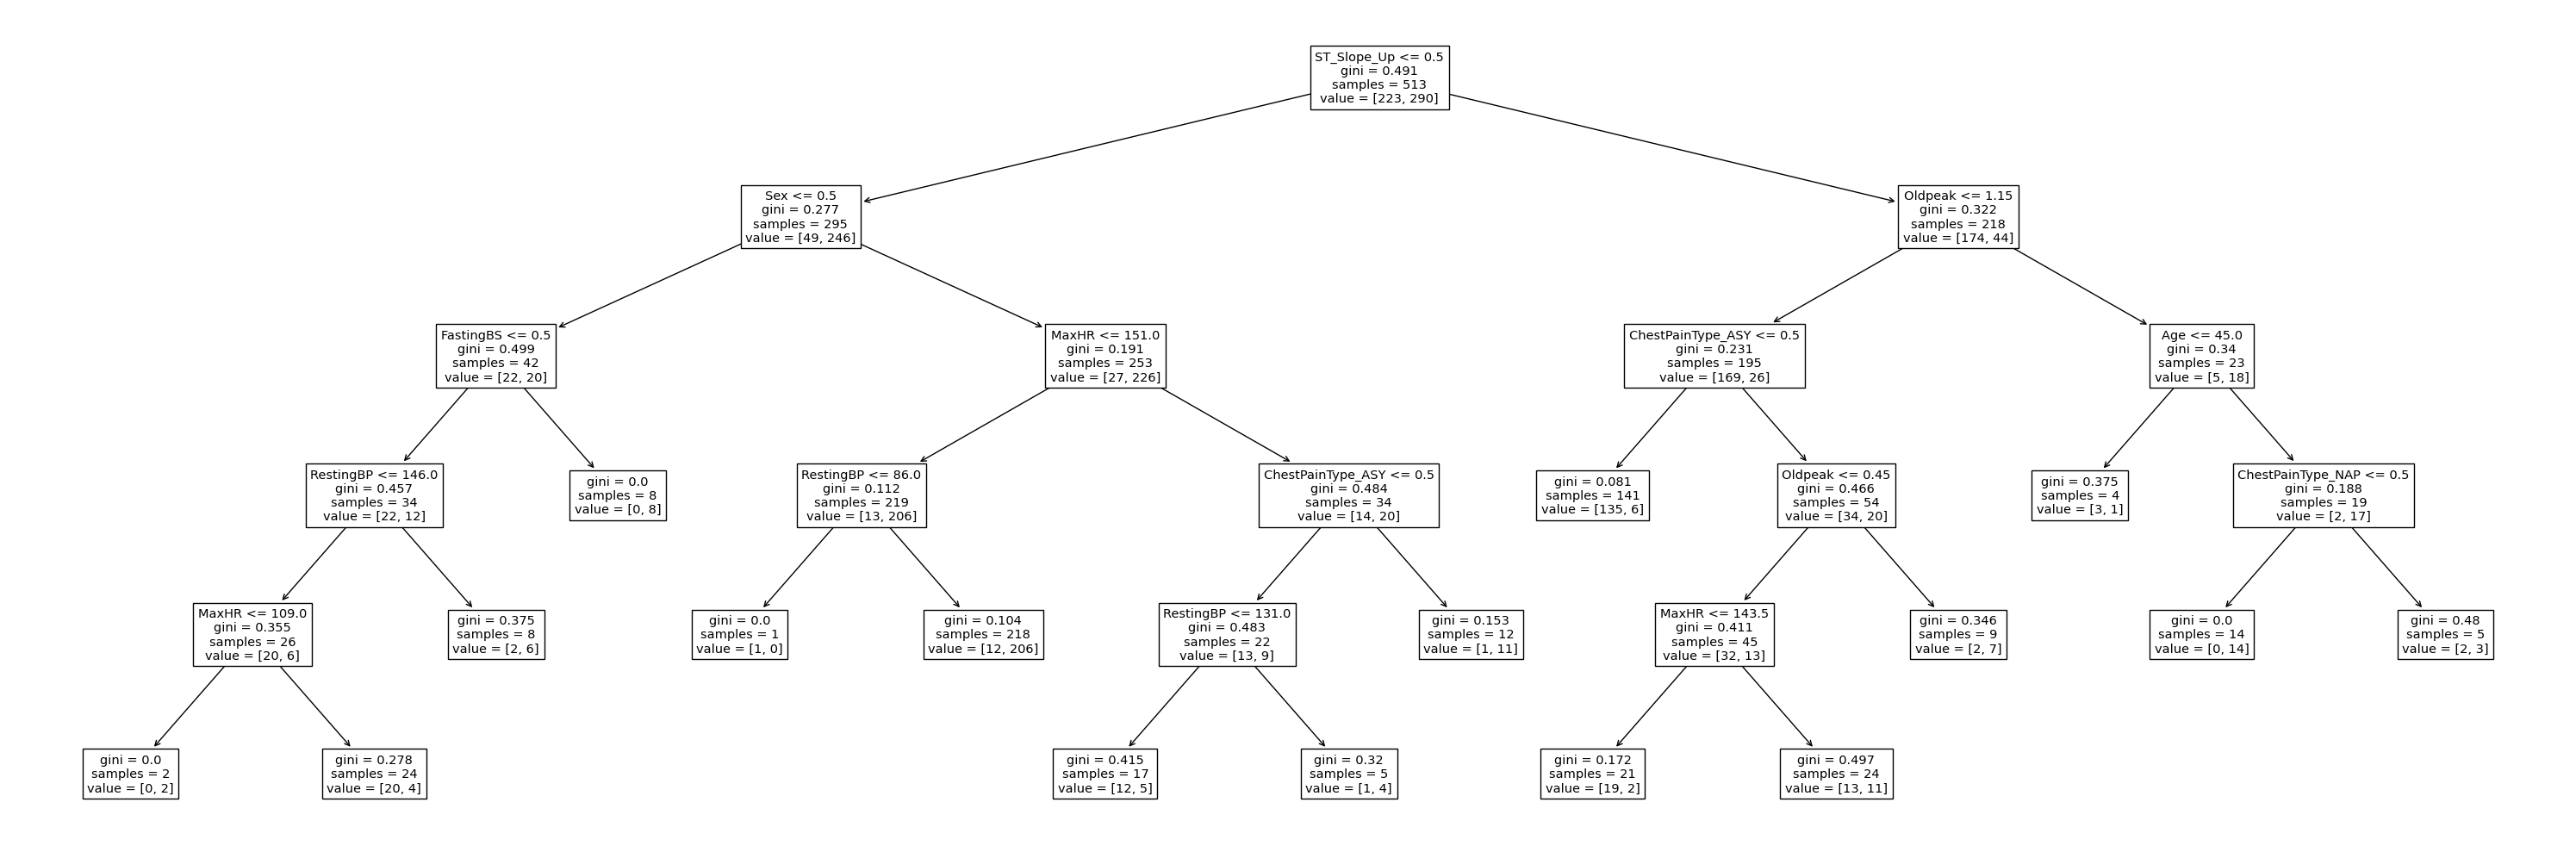

importance [0.01567547 0.07151177 0.04025033 0.03094404 0.0731935  0.         0.11943431 0.07071584 0.         0.0067272  0.         0.         0.         0.         0.         0.         0.57154754]
importanceが大きい順 ['ST_Slope_Up' 'Oldpeak' 'MaxHR' 'Sex' 'ChestPainType_ASY' 'RestingBP' 'FastingBS' 'Age' 'ChestPainType_NAP' 'ST_Slope_Flat' 'ChestPainType_TA' 'ExerciseAngina' 'RestingECG_LVH' 'RestingECG_Normal'
 'RestingECG_ST' 'ST_Slope_Down' 'ChestPainType_ATA']


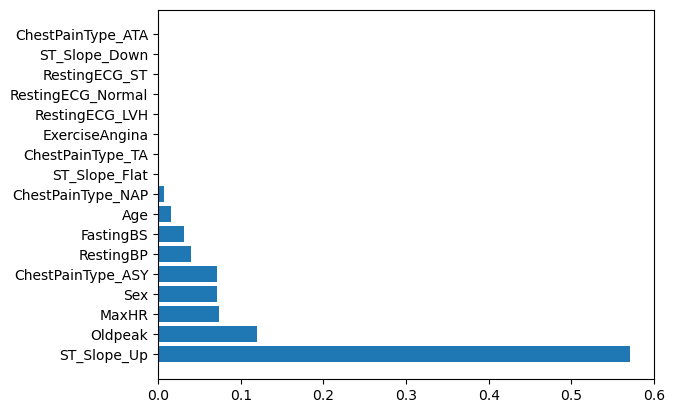

In [248]:
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=5,
                                    max_leaf_nodes=16,
                                    min_samples_split=10,
                                    random_state=1)
tree_model.fit(X_train, y_train)

print('学習用データでの正解率:', (tree_model.predict(X_train) == y_train).mean())
print('テスト用データでの正解率:', (tree_model.predict(X_test) == y_test).mean())

plt.figure(figsize=(30, 10))
tree.plot_tree(tree_model, feature_names=cols, fontsize=10.5)
plt.tight_layout()
plt.show()

importance = tree_model.feature_importances_
print('importance', importance)

index = np.argsort(importance)[::-1]
print('importanceが大きい順', np.array(cols)[index])

plt.barh(np.array(cols)[index], importance[index])
plt.show()

### ランダムフォレスト

 1) ST_Slope_Up                    0.216285
 2) ST_Slope_Flat                  0.151550
 3) ChestPainType_ASY              0.139792
 4) Oldpeak                        0.120639
 5) ExerciseAngina                 0.075961
 6) MaxHR                          0.066699
 7) Sex                            0.051646
 8) Age                            0.046933
 9) ChestPainType_ATA              0.034279
10) RestingBP                      0.030848
11) FastingBS                      0.022653
12) ChestPainType_NAP              0.014319
13) ST_Slope_Down                  0.008628
14) RestingECG_LVH                 0.008592
15) RestingECG_Normal              0.005827
16) ChestPainType_TA               0.002930
17) RestingECG_ST                  0.002418


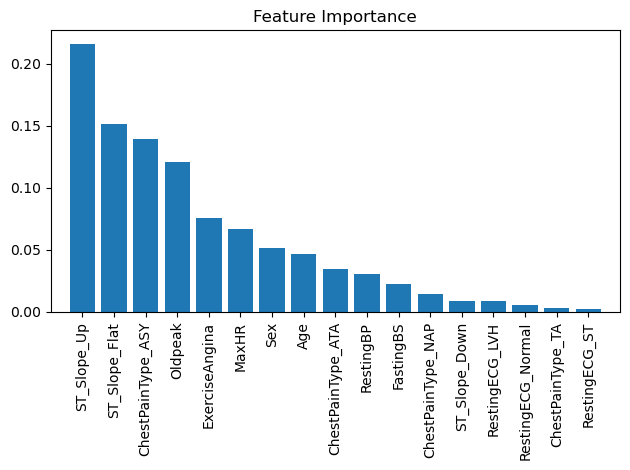

oob 0.8635477582846004


In [237]:
feat_labels = cols

forest = RandomForestClassifier(n_estimators=1000,
                                max_leaf_nodes=16,
                                max_features='sqrt',
                                oob_score=True,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

print('oob', forest.oob_score_)

## 特徴量抽出

### LDA

In [188]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_ss, y_train)

lr = LogisticRegression(multi_class='auto', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

print('学習用データでの正解率:', (lr.predict(lda.transform(X_train_ss)) == y_train).mean())
print('テスト用データでの正解率:', (lr.predict(lda.transform(X_test_ss)) == y_test).mean())

学習用データでの正解率: 0.8187134502923976
テスト用データでの正解率: 0.8372093023255814


# 予測

## ロジスティック回帰(限界がある)

solverとpenaltyの使用可能な組み合わせ
- 'lbfgs'           -   ['l2', None]
- 'liblinear'       -   ['l1', 'l2']
- 'newton-cg'       -   ['l2', None]
- 'newton-cholesky' -   ['l2', None]
- 'sag'             -   ['l2', None]
- 'saga'            -   ['elasticnet', 'l1', 'l2', None]

In [264]:
# ロジスティック回帰

# logi = LogisticRegression(C=1, solver='lbfgs', penalty='l2')
logi = LogisticRegression(C=0.08, solver='liblinear', penalty='l1')
logi.fit(X_train_ss, y_train)

print('学習用データでの正解率:', (logi.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (logi.predict(X_test_ss) == y_test).mean())
print('切片:', logi.intercept_)
display(pd.DataFrame({'変数名': cols, '係数': logi.coef_[0]}))
cols_lasso = cols[np.where(logi.coef_[0] != 0)]

学習用データでの正解率: 0.8674463937621832
テスト用データでの正解率: 0.8449612403100775
切片: [0.19458305]


,変数名,係数
0,Age,0.105543
1,Sex,0.589105
2,RestingBP,0.000000
3,FastingBS,0.345931
4,MaxHR,-0.056068
5,ExerciseAngina,0.209340
6,Oldpeak,0.323726
7,ChestPainType_ASY,0.682395
8,ChestPainType_ATA,-0.090226
9,ChestPainType_NAP,0.000000


## RBFカーネルSVM

In [260]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.05, C=0.4)
svm.fit(X_train_ss, y_train)
print('学習用データでの正解率:', (svm.predict(X_train_ss) == y_train).mean())
print('テスト用データでの正解率:', (svm.predict(X_test_ss) == y_test).mean())

学習用データでの正解率: 0.9005847953216374
テスト用データでの正解率: 0.8682170542635659
